In [1]:
pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.1 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 7.0 MB/s eta 0:00:000:00:0100:01
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803373 sha256=8bba815ed9adc1ae13de917a5961aaf45652b0c149569165dc91b9d7146f6be3
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.7 MB/s eta 0:00:0000:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


In [3]:
!pip install ffmpeg-python

In [12]:
import whisper
import subprocess
import os
import io
import random
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from easyocr import Reader
from transformers import WhisperProcessor
from torch.utils.data import DataLoader, Dataset
from torch import nn
import re
import soundfile as sf
from jiwer import wer, cer  
from tqdm import tqdm 
import ffmpeg
import librosa.display

# Dataset Path

In [5]:
audio_dir = '/kaggle/input/captcha-dataset/captchas/audio'
images_dir = '/kaggle/input/captcha-dataset/captchas/images'

audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

print(f"Total audio files: {len(audio_files)}")
print(f"Total image files: {len(image_files)}")

Total audio files: 10000
Total image files: 10000


# Preprocessing Steps - Normalization & Volume Enhancement

In [6]:
input_dir = "/kaggle/input/captcha-dataset/captchas/audio"
processed_audio_dir = "/kaggle/working/processed_audio"  # Output directory for processed audio

if not os.path.exists(processed_audio_dir):
    os.makedirs(processed_audio_dir)

all_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]

random_files = random.sample(all_files, 2500)

for filename in random_files:
    file_path = os.path.join(input_dir, filename)

    # Use FFmpeg to process audio
    process = subprocess.run(
        ["ffmpeg", "-i", file_path, "-af", "volume=1.2,loudnorm", "-acodec", "pcm_s16le", "-f", "wav", "pipe:1"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )

    audio_io = io.BytesIO(process.stdout)
    waveform, sample_rate = torchaudio.load(audio_io)

    processed_file_path = os.path.join(processed_audio_dir, filename)
    torchaudio.save(processed_file_path, waveform, sample_rate)

print("Preprocessing completed for 2500 random samples and saved to", processed_audio_dir)

Preprocessing completed for 2500 random samples and saved to /kaggle/working/processed_audio


# Spectrogram Comparison

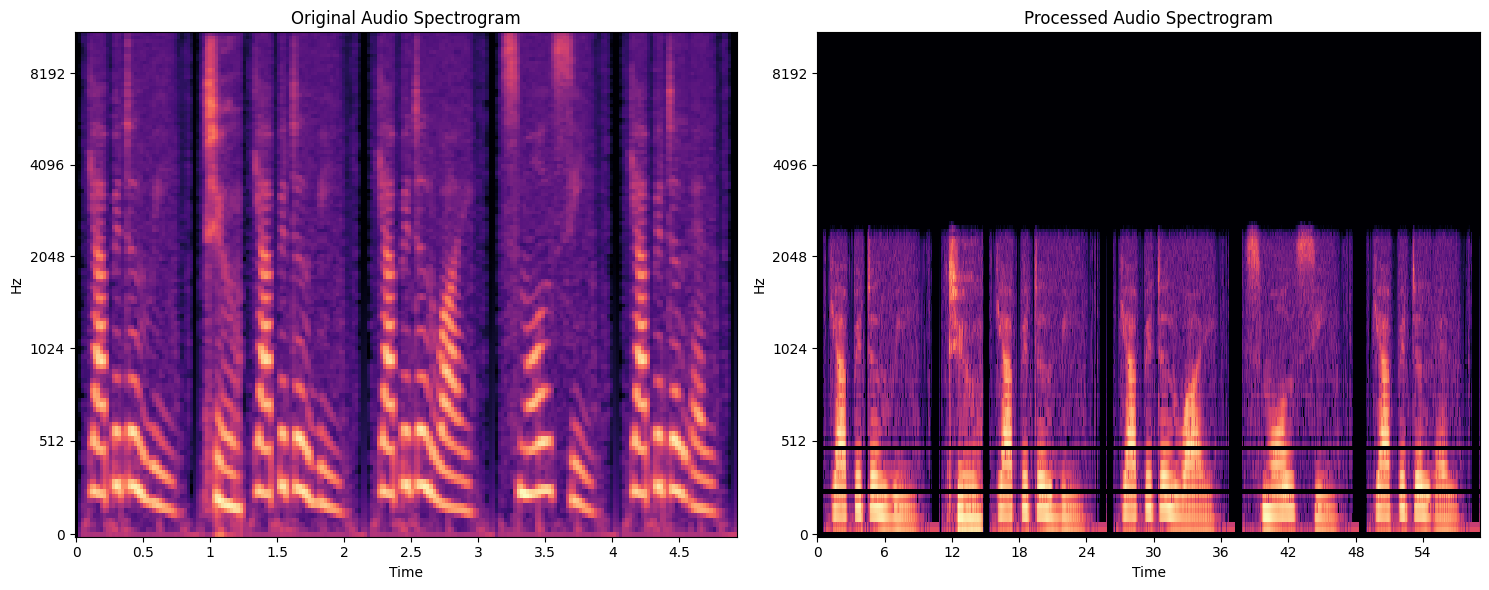

In [13]:
random_file = random.choice(os.listdir(processed_audio_dir))
file_name = random_file.split('.')[0]

# Get the corresponding original file in the input directory
original_file_path = os.path.join(input_dir, file_name + '.wav')
processed_file_path = os.path.join(processed_audio_dir, random_file)

original_waveform, original_sample_rate = torchaudio.load(original_file_path)
processed_waveform, processed_sample_rate = torchaudio.load(processed_file_path)

original_spectrogram = librosa.feature.melspectrogram(y=original_waveform.numpy()[0], sr=original_sample_rate)
processed_spectrogram = librosa.feature.melspectrogram(y=processed_waveform.numpy()[0], sr=processed_sample_rate)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

librosa.display.specshow(librosa.power_to_db(original_spectrogram, ref=np.max), y_axis='mel', x_axis='time', ax=axes[0])
axes[0].set_title('Original Audio Spectrogram')

librosa.display.specshow(librosa.power_to_db(processed_spectrogram, ref=np.max), y_axis='mel', x_axis='time', ax=axes[1])
axes[1].set_title('Processed Audio Spectrogram')

plt.tight_layout()
plt.show()

# Implementing Whisper AI and OCR to show outputs of 10 random samples

In [7]:
audio_dir = '/kaggle/working/processed_audio'
image_dir = '/kaggle/input/captcha-dataset/captchas/images'

ocr_reader = Reader(['en'])  # EasyOCR setup
whisper_model = whisper.load_model("medium")  # Whisper model

# Dictionary to convert number words to digits
number_map = {
    "zero": "0", "one": "1", "two": "2", "three": "3", "four": "4",
    "five": "5", "six": "6", "seven": "7", "eight": "8", "nine": "9"
}

# Dictionary for common misheard words
misheard_map = {
    "mall": "small", "moll": "small", "capitun": "capital", "capitan": "capital",
    "apital": "capital", "capitole": "capital", "zimro": "0", "smaller": "a"
}

# Step 1: Replace number words with digits
def replace_number_words(text):
    for word, digit in number_map.items():
        text = re.sub(rf"\b{word}\b", digit, text, flags=re.IGNORECASE)
    return text

# Step 2: Fix common misheard words
def fix_misheard_words(text):
    for wrong, correct in misheard_map.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)
    return text

# Step 3: Replace "for" with "4"
def replace_for_with_4(text):
    text = re.sub(r"\bfor\b", "4", text, flags=re.IGNORECASE)
    return text

# Step 4: Process capitalization and handle "edge" replacement
def process_capitalization(text):
    matches = re.findall(r"(capital|small) (\w+)", text, re.IGNORECASE)
    cleaned_text = ""

    i = 0
    while i < len(text):
        match_found = False
        
        for match in matches:
            marker, letter = match
            marker_index = text.lower().find(f"{marker.lower()} {letter.lower()}")
            
            if marker_index == i:
                if marker.lower() == "capital":
                    cleaned_text += letter.upper()
                else:
                    cleaned_text += letter.lower()
                i += len(marker) + 2
                match_found = True
                break

        if not match_found:
            cleaned_text += text[i]
            i += 1

    # Handle "edge" replacement based on the previous marker
    cleaned_text = re.sub(r"\bsmall\s+edge\b", "h", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bcapital\s+edge\b", "H", cleaned_text, flags=re.IGNORECASE)

    # Remove remaining "capital" or "small" words
    cleaned_text = re.sub(r"\b(capital|small)\b", "", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"[^a-zA-Z0-9]", "", cleaned_text)  # Keep only A-Z, a-z, 0-9
    return cleaned_text

def get_whisper_transcription(audio_file):
    text = ""
    
    # Try Whisper transcription up to 3 times if length is < 6
    for _ in range(3):
        result = whisper_model.transcribe(audio_file)
        text = result["text"]
        text = replace_number_words(text)  # Replace number words with digits
        text = fix_misheard_words(text)  # Fix misheard words
        text = replace_for_with_4(text)  # Replace "for" with "4"
        text = process_capitalization(text)  # Process capitalization & "edge"
        
        if len(text) >= 6:  # Ensure minimum length of 6
            break

    return text[:6]  # Ensure the output is exactly 6 characters

def get_image_text(image_file):
    ocr_result = ocr_reader.readtext(image_file)
    text = ''.join([res[1] for res in ocr_result])
    return text

def process_random_samples(audio_dir, image_dir, num_samples=10):
    audio_files = random.sample(os.listdir(audio_dir), num_samples)
    
    for audio_file in audio_files:
        audio_path = os.path.join(audio_dir, audio_file)
        image_file = audio_file.replace('.wav', '.png')  # Assuming same filename for audio and image
        image_path = os.path.join(image_dir, image_file)
        
        # Get transcription from Whisper
        whisper_text = get_whisper_transcription(audio_path)
        
        # Get ground truth text from EasyOCR
        ground_truth_text = get_image_text(image_path)
        
        # Print results for comparison
        print(f"Audio file: {audio_file}")
        print(f"Whisper AI Transcription: {whisper_text}")
        print(f"Ground Truth (OCR): {ground_truth_text}")
        print("="*50)

process_random_samples(audio_dir, image_dir, num_samples=10)

100%|█████████████████████████████████████| 1.42G/1.42G [00:22<00:00, 67.0MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Audio file: captcha_9452.wav
Whisper AI Transcription: smQDbA
Ground Truth (OCR): smQDbA
Audio file: captcha_9206.wav
Whisper AI Transcription: sP5kpa
Ground Truth (OCR): sPSkpa
Audio file: captcha_1755.wav
Whisper AI Transcription: 6ajmJy
Ground Truth (OCR): 6ajmJy
Audio file: captcha_9501.wav
Whisper AI Transcription: KZiOKC
Ground Truth (OCR): KZiOKC
Audio file: captcha_3590.wav
Whisper AI Transcription: vxClFA
Ground Truth (OCR): dxCIFA
Audio file: captcha_8609.wav
Whisper AI Transcription: KyUvqA
Ground Truth (OCR): KyUvqA
Audio file: captcha_8114.wav
Whisper AI Transcription: y0czO
Ground Truth (OCR): YOczzo
Audio file: captcha_7849.wav
Whisper AI Transcription: DFFU9S
Ground Truth (OCR): DFFU9S
Audio file: captcha_0049.wav
Whisper AI Transcription: 4OPnyT
Ground Truth (OCR): 4OPnyT
Audio file: captcha_2228.wav
Whisper AI Transcription: ITocLH
Ground Truth (OCR): ITocLH


# Transcription Accuracy & No. of Text Match Scores

In [9]:
audio_dir = '/kaggle/working/processed_audio'
image_dir = '/kaggle/input/captcha-dataset/captchas/images'

ocr_reader = Reader(['en'])  # EasyOCR setup
whisper_model = whisper.load_model("medium")

number_map = {
    "zero": "0", "one": "1", "two": "2", "three": "3", "four": "4",
    "five": "5", "six": "6", "seven": "7", "eight": "8", "nine": "9"
}

# Dictionary for common misheard words
misheard_map = {
    "mall": "small", "moll": "small", "capitun": "capital", "capitan": "capital",
    "apital": "capital", "capitole": "capital", "zimro": "0", "smaller": "a"
}

# Step 1: Replace number words with digits
def replace_number_words(text):
    for word, digit in number_map.items():
        text = re.sub(rf"\b{word}\b", digit, text, flags=re.IGNORECASE)
    return text

# Step 2: Fix common misheard words
def fix_misheard_words(text):
    for wrong, correct in misheard_map.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)
    return text

# Step 3: Replace "for" with "4"
def replace_for_with_4(text):
    text = re.sub(r"\bfor\b", "4", text, flags=re.IGNORECASE)
    return text

# Step 4: Process capitalization and handle "edge" replacement
def process_capitalization(text):
    matches = re.findall(r"(capital|small) (\w+)", text, re.IGNORECASE)
    cleaned_text = ""

    i = 0
    while i < len(text):
        match_found = False
        
        for match in matches:
            marker, letter = match
            marker_index = text.lower().find(f"{marker.lower()} {letter.lower()}")
            
            if marker_index == i:
                if marker.lower() == "capital":
                    cleaned_text += letter.upper()
                else:
                    cleaned_text += letter.lower()
                i += len(marker) + 2
                match_found = True
                break

        if not match_found:
            cleaned_text += text[i]
            i += 1

    # Handle "edge" replacement based on the previous marker
    cleaned_text = re.sub(r"\bsmall\s+edge\b", "h", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bcapital\s+edge\b", "H", cleaned_text, flags=re.IGNORECASE)

    # Remove remaining "capital" or "small" words
    cleaned_text = re.sub(r"\b(capital|small)\b", "", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"[^a-zA-Z0-9]", "", cleaned_text)  # Keep only A-Z, a-z, 0-9
    return cleaned_text

def get_whisper_transcription(audio_file):
    text = ""
    
    # Try Whisper transcription up to 3 times if length is < 6
    for _ in range(3):
        result = whisper_model.transcribe(audio_file)
        text = result["text"]
        text = replace_number_words(text)  # Replace number words with digits
        text = fix_misheard_words(text)  # Fix misheard words
        text = replace_for_with_4(text)  # Replace "for" with "4"
        text = process_capitalization(text)  # Process capitalization & "edge"
        
        if len(text) >= 6:  # Ensure minimum length of 6
            break

    return text[:6]  # Ensure the output is exactly 6 characters

def get_image_text(image_file):
    ocr_result = ocr_reader.readtext(image_file)
    text = ''.join([res[1] for res in ocr_result])
    return text

def process_all_samples(audio_dir, image_dir):
    all_files = os.listdir(audio_dir)
    total_files = len(all_files)
    cer_scores = []
    exact_matches = 0  # Initialize counter for exact matches
    
    for i, audio_file in enumerate(tqdm(all_files, desc="Processing")):
        audio_path = os.path.join(audio_dir, audio_file)
        image_file = audio_file.replace('.wav', '.png') 
        image_path = os.path.join(image_dir, image_file)

        whisper_text = get_whisper_transcription(audio_path)

        ground_truth_text = get_image_text(image_path)

        if not ground_truth_text or not whisper_text:
            continue  

        # Compute CER (Character Error Rate)
        error_rate = cer(ground_truth_text, whisper_text)  # CER calculation
        accuracy = max(0, 100 - (error_rate * 100))  
        cer_scores.append(accuracy)

        # Check for exact matches
        if whisper_text == ground_truth_text:
            exact_matches += 1

        if (i + 1) % 500 == 0:
            avg_accuracy = sum(cer_scores) / len(cer_scores)
            print(f"\nProgress: {i+1}/{total_files} samples processed. Current Accuracy: {avg_accuracy:.2f}%\n")

    avg_accuracy = sum(cer_scores) / len(cer_scores) if cer_scores else 0
    print(f"\nFinal Accuracy after processing {total_files} samples: {avg_accuracy:.2f}%")
    print(f"Exact Matches: {exact_matches}/{total_files} ({(exact_matches / total_files) * 100:.2f}%)")

process_all_samples(audio_dir, image_dir)

/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
Processing:  


Progress: 500/2500 samples processed. Current Accuracy: 78.85%



Processing:  40%|████      | 1000/2500 [21:42<29:03,  1.16s/it] 


Progress: 1000/2500 samples processed. Current Accuracy: 79.20%



Processing:  60%|██████    | 1500/2500 [32:57<22:35,  1.36s/it]  


Progress: 1500/2500 samples processed. Current Accuracy: 79.25%



Processing:  80%|████████  | 2000/2500 [43:48<10:28,  1.26s/it]


Progress: 2000/2500 samples processed. Current Accuracy: 79.42%



Processing: 100%|██████████| 2500/2500 [54:37<00:00,  1.31s/it]


Progress: 2500/2500 samples processed. Current Accuracy: 79.40%


Final Accuracy after processing 2500 samples: 79.40%
Exact Matches: 761/2500 (30.44%)
